# **Target 5:**

less than 10k params
uses dropout of 0.05
uses batchnorm
uses randomrotate transform
uses StepLR with step size = 6 and gamma = 0.1
Achieve 99.4% test accuracy


**Results 5:**

After 15 epochs

Training accuracy 99.03:
Test accuracy 99.52%

After 20 epochs

Training accuracy 99.00:
Test accuracy 99.48%

**Analysis 5:**



•	Decreasing Step Size made model performance worse




•	Revert to Model 3

•	Reduced parameters 

•	Decreased Batch Size

•	Model is achieving good accuracy on Test

•	Parameters are under 10K – 8700 

•	Achieving Target as desired on consistent basis

•	Best Accuracy 99.52  , in  15 epochs



# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [6]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [7]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=32, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [0]:
import torch.nn.functional as F
dropout_value = 0.05
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # Input_size: 28x28x1 | output_size: 26x26x8 | receptive field: 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # Input_size: 26x26x8 | output_size: 24x24x10 | receptive field: 5

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
        ) # Input_size: 24x24x10 | output_size: 22x22x12 | receptive field: 7

         # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # Input_size: 22x22x12 | output_size: 11x11x12 | receptive field: 8

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # Input_size: 11x11x12 | output_size: 9x9x16 | receptive field: 12

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # Input_size: 9x9x16 | output_size: 7x7x16 | receptive field: 16
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
        ) # Input_size: 7x7x16 | output_size: 5x5x16 | receptive field: 20

        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            
        ) # Input_size: 1x1x10 | output_size: 1x1x10 | receptive field: 28
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=1)
        ) # Input_size: 5x5x16 | output_size: 1x1x16 | receptive field: 28
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            
        ) # Input_size: 1x1x16 | output_size: 1x1x10 | receptive field: 28

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            
        ) # Input_size: 1x1x10 | output_size: 1x1x10 | receptive field: 28
        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            
        ) # Input_size: 1x1x10 | output_size: 1x1x10 | receptive field: 28


    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [9]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             720
              ReLU-6           [-1, 10, 24, 24]               0
       BatchNorm2d-7           [-1, 10, 24, 24]              20
           Dropout-8           [-1, 10, 24, 24]               0
            Conv2d-9           [-1, 12, 22, 22]           1,080
        MaxPool2d-10           [-1, 12, 11, 11]               0
           Conv2d-11             [-1, 16, 9, 9]           1,728
             ReLU-12             [-1, 16, 9, 9]               0
      BatchNorm2d-13             [-1, 16, 9, 9]              32
          Dropout-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [11]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/1875 [00:00<?, ?it/s]

EPOCH: 1


Loss=0.014726325869560242 Batch_id=1874 Accuracy=89.35: 100%|██████████| 1875/1875 [00:25<00:00, 73.20it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0569, Accuracy: 9831/10000 (98.31%)

EPOCH: 2


Loss=0.026398181915283203 Batch_id=1874 Accuracy=97.28: 100%|██████████| 1875/1875 [00:25<00:00, 74.30it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0321, Accuracy: 9899/10000 (98.99%)

EPOCH: 3


Loss=0.14108625054359436 Batch_id=1874 Accuracy=97.89: 100%|██████████| 1875/1875 [00:25<00:00, 73.78it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0349, Accuracy: 9894/10000 (98.94%)

EPOCH: 4


Loss=0.21285800635814667 Batch_id=1874 Accuracy=98.08: 100%|██████████| 1875/1875 [00:26<00:00, 71.36it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Accuracy: 9912/10000 (99.12%)

EPOCH: 5


Loss=0.002914935350418091 Batch_id=1874 Accuracy=98.30: 100%|██████████| 1875/1875 [00:26<00:00, 72.08it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9918/10000 (99.18%)

EPOCH: 6


Loss=0.01619933545589447 Batch_id=1874 Accuracy=98.41: 100%|██████████| 1875/1875 [00:26<00:00, 71.43it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9928/10000 (99.28%)

EPOCH: 7


Loss=0.007931262254714966 Batch_id=1874 Accuracy=98.81: 100%|██████████| 1875/1875 [00:25<00:00, 74.47it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9937/10000 (99.37%)

EPOCH: 8


Loss=0.004929214715957642 Batch_id=1874 Accuracy=98.94: 100%|██████████| 1875/1875 [00:25<00:00, 74.49it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9944/10000 (99.44%)

EPOCH: 9


Loss=0.06426453590393066 Batch_id=1874 Accuracy=98.92: 100%|██████████| 1875/1875 [00:25<00:00, 74.09it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9946/10000 (99.46%)

EPOCH: 10


Loss=0.001650482416152954 Batch_id=1874 Accuracy=98.96: 100%|██████████| 1875/1875 [00:24<00:00, 75.04it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9944/10000 (99.44%)

EPOCH: 11


Loss=0.008388623595237732 Batch_id=1874 Accuracy=99.05: 100%|██████████| 1875/1875 [00:25<00:00, 73.38it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Accuracy: 9949/10000 (99.49%)

EPOCH: 12


Loss=0.0077192336320877075 Batch_id=1874 Accuracy=99.03: 100%|██████████| 1875/1875 [00:25<00:00, 73.05it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 9950/10000 (99.50%)

EPOCH: 13


Loss=0.008675366640090942 Batch_id=1874 Accuracy=99.05: 100%|██████████| 1875/1875 [00:25<00:00, 73.59it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9952/10000 (99.52%)

EPOCH: 14


Loss=0.0676100105047226 Batch_id=1874 Accuracy=99.05: 100%|██████████| 1875/1875 [00:25<00:00, 74.29it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9949/10000 (99.49%)

EPOCH: 15


Loss=0.012785255908966064 Batch_id=1874 Accuracy=99.03: 100%|██████████| 1875/1875 [00:25<00:00, 72.19it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9952/10000 (99.52%)

EPOCH: 16


Loss=0.01353675127029419 Batch_id=1874 Accuracy=99.08: 100%|██████████| 1875/1875 [00:25<00:00, 80.98it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9951/10000 (99.51%)

EPOCH: 17


Loss=0.03152334690093994 Batch_id=1874 Accuracy=98.98: 100%|██████████| 1875/1875 [00:25<00:00, 74.33it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9945/10000 (99.45%)

EPOCH: 18


Loss=0.03652510046958923 Batch_id=1874 Accuracy=99.04: 100%|██████████| 1875/1875 [00:25<00:00, 74.18it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9946/10000 (99.46%)

EPOCH: 19


Loss=0.0005900561809539795 Batch_id=1874 Accuracy=99.04: 100%|██████████| 1875/1875 [00:25<00:00, 74.13it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9948/10000 (99.48%)

EPOCH: 20


Loss=0.002426356077194214 Batch_id=1874 Accuracy=99.00: 100%|██████████| 1875/1875 [00:25<00:00, 74.09it/s]



Test set: Average loss: 0.0169, Accuracy: 9948/10000 (99.48%)



# Let's Train and test our model

This time let's add a scheduler for out LR. 

Text(0.5, 1.0, 'Test Accuracy')

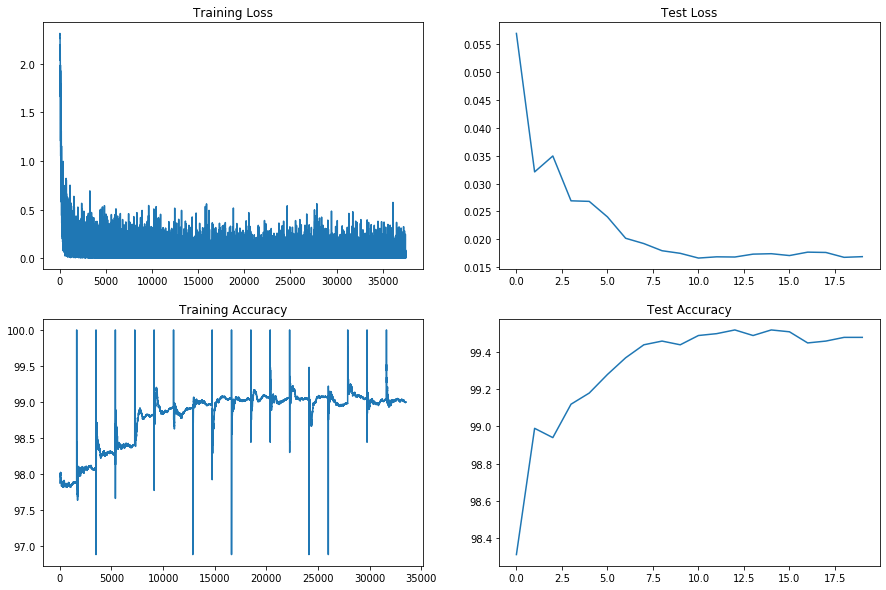

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")